In [2]:
# Importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import random
from scipy.io import arff

# 1. Configurações Gerais

In [3]:
# Exibe todas as colunas
pd.set_option('display.max_columns', None)

# 2. Carregando Dataset

Fonte: Tan, Choon Lin (2018), “Phishing Dataset for Machine Learning: Feature Evaluation”, Mendeley Data, V1, doi: 10.17632/h3cgnj8hft.1

In [4]:
# Carrega o arquivo ARFF
caminho_do_arquivo = '/content/dataset.arff'
data, meta = arff.loadarff(caminho_do_arquivo)

df = pd.DataFrame(data)

for coluna in df.columns:
    if df[coluna].dtype == 'object' and isinstance(df[coluna][0], bytes):
        df[coluna] = df[coluna].str.decode('utf-8')

In [5]:
df

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,3.0,1.0,5.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21.0,44.0,0.0,0.0,0.0,0.0,0.000000,0.250000,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,-1.0,1.0,1
1,3.0,1.0,3.0,144.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,41.0,1.0,0.0,0.0,0.0,0.0,0.0,17.0,16.0,103.0,0.0,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,1.0,1
2,3.0,1.0,2.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.0,24.0,0.0,0.0,0.0,0.0,0.375000,1.000000,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,-1.0,0.0,1
3,3.0,1.0,6.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,22.0,50.0,0.0,0.0,0.0,1.0,1.000000,0.095238,1.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1
4,3.0,0.0,4.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,10.0,29.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,-1.0,0.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.0,1.0,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,10.0,17.0,0.0,0.0,0.0,0.096774,0.757143,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,0.0,1.0,0
9996,2.0,1.0,4.0,59.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,19.0,33.0,0.0,0.0,0.0,0.0,0.161290,0.275862,0.0,1.0,0.0,0.0,0.0,0.129032,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
9997,2.0,1.0,4.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,16.0,34.0,0.0,0.0,0.0,0.0,0.070423,0.500000,0.0,1.0,0.0,0.0,0.0,0.056338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0
9998,3.0,1.0,1.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,13.0,13.0,0.0,0.0,0.0,0.166667,0.428571,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0


# 3. Pré-processamento dos dados

In [6]:
# Realiza o pré-processamento dos dados
X = df.drop('CLASS_LABEL', axis=1)
y = df['CLASS_LABEL']

# Mapeie '0' para 0 e '1' para 1
y = y.map({'0': 0, '1': 1})

# Padroniza as características (escalonamento)
escalador = StandardScaler()
X = escalador.fit_transform(X)

# 4. Métodos de amostragem

Os métodos de amostragem utilizados serão:

1. **Holdout (Amostragem Fixa):**

É como dividir um conjunto de dados em duas partes, geralmente 80% para treinamento e 20% para teste. Os dados são divididos uma única vez, e o modelo é treinado nos dados de treinamento e testado nos dados de teste. É uma técnica simples, mas pode variar os resultados dependendo de como os dados são divididos.


2. **R-fold Cross-Validation (Validação Cruzada com R Divisões):**

Divide o conjunto de dados em R partes iguais (por exemplo, 5 partes).
O modelo é treinado e testado R vezes, cada vez usando uma parte diferente como dados de teste e as outras partes como dados de treinamento.
As métricas de desempenho são médias das R iterações.
Ajuda a obter uma estimativa mais estável do desempenho do modelo.


3. **Stratified K-Fold Cross-Validation (Validação Cruzada Estratificada com K Divisões):**

Semelhante à validação cruzada, mas mantém a proporção de classes (rótulos) em cada dobra.
Útil quando os dados têm um desequilíbrio entre as classes.
O modelo é treinado e testado K vezes, garantindo que cada dobra tenha uma representação justa de todas as classes.


4. **Stratified Shuffle Split (Divisão Estratificada Aleatória):**

Mistura aleatoriamente os dados e, em seguida, divide-os em conjuntos de treinamento e teste.
Mantém a proporção de classes (rótulos) nas divisões.
Pode ser útil quando você deseja fazer várias divisões aleatórias estratificadas.


5. **Shuffle Split (Divisão Aleatória):**

Mistura aleatoriamente os dados e, em seguida, divide-os em conjuntos de treinamento e teste sem se preocupar com a estratificação.
Pode ser usado quando a estratificação não é crítica e você deseja avaliar o modelo em várias divisões aleatórias.

In [7]:
# Métodos de amostragem
metodos_amostragem = {
    "Holdout": train_test_split,
    "R-fold Cross-Validation": KFold(n_splits=5, shuffle=True, random_state=42),
    "Stratified K-Fold": StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    "Stratified Shuffle Split": StratifiedShuffleSplit(n_splits=5, random_state=42),
    "Shuffle Split": ShuffleSplit(n_splits=5, random_state=42)
}

# 5. Modelo usando KNN



Acurácia do Holdout (KNN): 0.9500
Acurácia média usando R-fold Cross-Validation (KNN): 0.9502
Acurácia média usando Stratified K-Fold (KNN): 0.9497
Acurácia média usando Stratified Shuffle Split (KNN): 0.9594
Acurácia média usando Shuffle Split (KNN): 0.9568

Métricas Detalhadas para o Melhor Método de Amostragem:
Método: Stratified Shuffle Split
Acurácia: 0.9594
Matriz de Confusão:
 [[477.4  22.6]
 [ 18.  482. ]]
Relatório de Classificação:
 

Média dos Relatórios de Classificação:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       500
           1       0.97      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       500
           1       0.95      0.95      0.95       500

    accuracy       

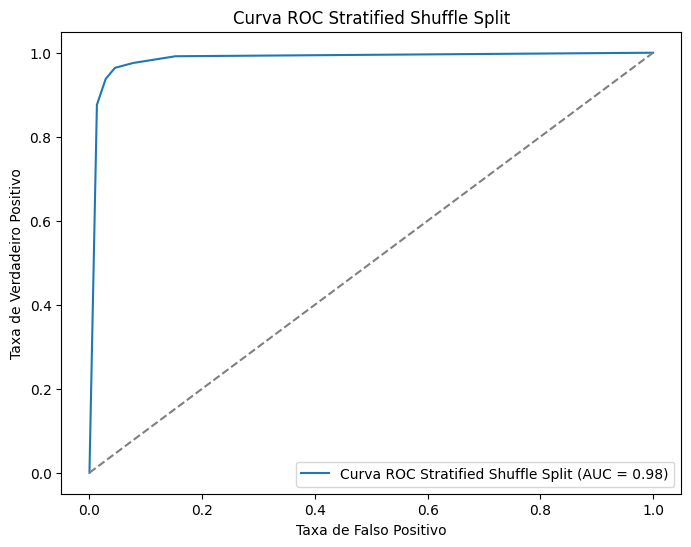

In [12]:
# Variáveis para armazenar as métricas do melhor método
melhor_metodo_nome = None
melhor_metodo_acuracia = 0.0
melhor_metodo_metricas = {}

# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)

for metodo_nome, metodo in metodos_amostragem.items():
    if metodo_nome == "Holdout":
        # Realiza holdout com 80% treinamento e 20% teste
        X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

        # Treina o modelo KNN
        knn.fit(X_treinamento, y_treinamento)

        # Realiza previsões no conjunto de teste (holdout)
        y_predito_knn = knn.predict(X_teste)

        # Calcula a acurácia para o método de holdout
        acuracia_knn = accuracy_score(y_teste, y_predito_knn)

        # Imprime a acurácia do método de holdout
        print(f"Acurácia do {metodo_nome} (KNN): {acuracia_knn:.4f}")

        # Verifica se o método de holdout é o melhor até agora
        if acuracia_knn > melhor_metodo_acuracia:
            melhor_metodo_nome = metodo_nome
            melhor_metodo_acuracia = acuracia_knn
            melhor_metodo_metricas = {
                "Acuracia": acuracia_knn,
                "Matriz de Confusao": confusion_matrix(y_teste, y_predito_knn),
                "Relatorio de Classificacao": classification_report(y_teste, y_predito_knn),
                "Curva ROC": roc_curve(y_teste, knn.predict_proba(X_teste)[:, 1]),
                "AUC": roc_auc_score(y_teste, knn.predict_proba(X_teste)[:, 1])
            }
    else:
        # Utiliza o método de amostragem correspondente
        acuracias = cross_val_score(knn, X, y, cv=metodo, scoring='accuracy')
        acuracia_media = np.mean(acuracias)

        # Calcula a matriz de confusão, relatório de classificação, curva ROC e AUC usando validação cruzada
        matrizes_confusao = []
        relatorios_classificacao = []
        curvas_roc = []
        aucs = []

        for treino, teste in metodo.split(X, y):
            X_treinamento_cv, X_teste_cv = X[treino], X[teste]
            y_treinamento_cv, y_teste_cv = y[treino], y[teste]

            # Treina o modelo KNN
            knn.fit(X_treinamento_cv, y_treinamento_cv)

            # Realiza previsões no conjunto de teste (validação cruzada)
            y_predito_cv = knn.predict(X_teste_cv)

            # Calcula a matriz de confusão
            matriz_confusao_cv = confusion_matrix(y_teste_cv, y_predito_cv)
            matrizes_confusao.append(matriz_confusao_cv)

            # Calcula o relatório de classificação
            relatorio_classificacao_cv = classification_report(y_teste_cv, y_predito_cv)
            relatorios_classificacao.append(relatorio_classificacao_cv)

            # Calcula a curva ROC e AUC
            fpr, tpr, _ = roc_curve(y_teste_cv, knn.predict_proba(X_teste_cv)[:, 1])
            curvas_roc.append((fpr, tpr))
            auc = roc_auc_score(y_teste_cv, knn.predict_proba(X_teste_cv)[:, 1])
            aucs.append(auc)

        # Médias das métricas calculadas durante a validação cruzada
        matriz_confusao_media = np.mean(matrizes_confusao, axis=0)
        relatorio_classificacao_media = "\n\nMédia dos Relatórios de Classificação:\n\n" + "\n\n".join(relatorios_classificacao)
        curvas_roc_media = np.mean(curvas_roc, axis=0)
        auc_media = np.mean(aucs)

        # Imprime a acurácia média para o método de amostragem
        print(f"Acurácia média usando {metodo_nome} (KNN): {acuracia_media:.4f}")

        # Verifica se o método atual é o melhor até agora
        if acuracia_media > melhor_metodo_acuracia:
            melhor_metodo_nome = metodo_nome
            melhor_metodo_acuracia = acuracia_media
            melhor_metodo_metricas = {
                "Acuracia": acuracia_media,
                "Matriz de Confusao": matriz_confusao_media,
                "Relatorio de Classificacao": relatorio_classificacao_media,
                "Curva ROC": curvas_roc_media,
                "AUC": auc_media
            }

# Imprime as métricas detalhadas apenas para o melhor método de amostragem
print("\nMétricas Detalhadas para o Melhor Método de Amostragem:")
print(f"Método: {melhor_metodo_nome}")
print(f"Acurácia: {melhor_metodo_metricas['Acuracia']:.4f}")
print("Matriz de Confusão:\n", melhor_metodo_metricas['Matriz de Confusao'])
print("Relatório de Classificação:\n", melhor_metodo_metricas['Relatorio de Classificacao'])
print("Área sob a Curva ROC (AUC):", melhor_metodo_metricas['AUC'])

# Plota a curva ROC para o melhor método de amostragem
plt.figure(figsize=(8, 6))
fpr, tpr = melhor_metodo_metricas['Curva ROC']
plt.plot(fpr, tpr, label=f'Curva ROC {melhor_metodo_nome} (AUC = {melhor_metodo_metricas["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title(f'Curva ROC {melhor_metodo_nome}')
plt.legend(loc='lower right')
plt.show()

# 6. Modelo usando MLP

Acurácia do Holdout (MLP): 0.9730
Acurácia média usando R-fold Cross-Validation (MLP): 0.9759
Acurácia média usando Stratified K-Fold (MLP): 0.9770
Acurácia média usando Stratified Shuffle Split (MLP): 0.9796
Acurácia média usando Shuffle Split (MLP): 0.9840

Métricas Detalhadas para o Melhor Método de Amostragem:
Método: Shuffle Split
Acurácia: 0.9840
Matriz de Confusão:
 [[494.8   7.2]
 [  8.8 489.2]]
Relatório de Classificação:
 

Média dos Relatórios de Classificação:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       508
           1       0.98      0.98      0.98       492

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       490
           1       0.98      0.98      0.98       510

    accuracy                  

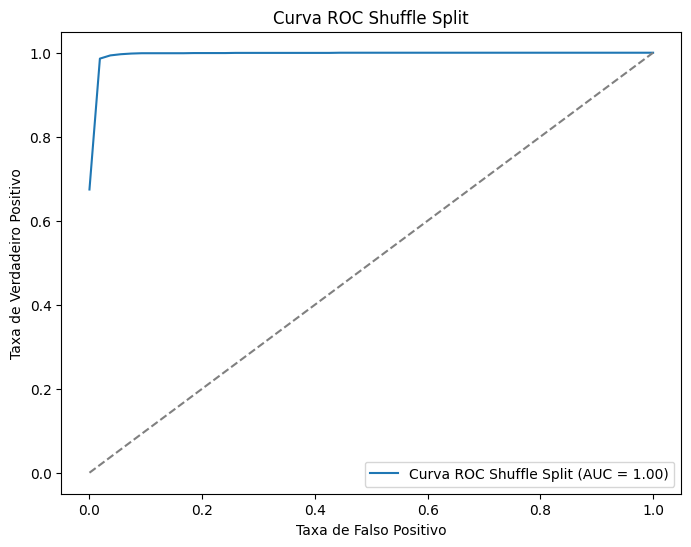

In [17]:
# Variáveis para armazenar as métricas do melhor método
melhor_metodo_nome = None
melhor_metodo_acuracia = 0.0
melhor_metodo_metricas = {}

# Modelo MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=2000,
    random_state=42,
    activation='relu',
    alpha=0.0001,
    solver='adam',
    learning_rate='constant',
    batch_size=32
)

for metodo_nome, metodo in metodos_amostragem.items():
    if metodo_nome == "Holdout":
        # Realiza holdout com 80% treinamento e 20% teste
        X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

        # Treina o modelo MLP
        mlp.fit(X_treinamento, y_treinamento)

        # Realiza previsões no conjunto de teste (holdout)
        y_predito_mlp = mlp.predict(X_teste)

        # Calcula a acurácia para o método de holdout
        acuracia_mlp = accuracy_score(y_teste, y_predito_mlp)

        # Imprime a acurácia do método de holdout
        print(f"Acurácia do {metodo_nome} (MLP): {acuracia_mlp:.4f}")

        # Calcula a matriz de confusão e o relatório de classificação para o método de holdout
        matriz_confusao_mlp = confusion_matrix(y_teste, y_predito_mlp, labels=np.unique(y))
        relatorio_classificacao_mlp = classification_report(y_teste, y_predito_mlp)

        # Verifica se o método de holdout é o melhor até agora
        if acuracia_mlp > melhor_metodo_acuracia:
            melhor_metodo_nome = metodo_nome
            melhor_metodo_acuracia = acuracia_mlp
            melhor_metodo_metricas = {
                "Acuracia": acuracia_mlp,
                "Matriz de Confusao": matriz_confusao_mlp,
                "Relatorio de Classificacao": relatorio_classificacao_mlp,
                "Curva ROC": roc_curve(y_teste, mlp.predict_proba(X_teste)[:, 1]),
                "AUC": roc_auc_score(y_teste, mlp.predict_proba(X_teste)[:, 1])
            }
    else:
        # Utiliza o método de amostragem correspondente
        acuracias = cross_val_score(mlp, X, y, cv=metodo, scoring='accuracy')
        acuracia_media = np.mean(acuracias)

        # Calcula a matriz de confusão, relatório de classificação, curva ROC e AUC usando validação cruzada
        matrizes_confusao = []
        relatorios_classificacao = []
        curvas_roc = []
        aucs = []

        for treino, teste in metodo.split(X, y):
            X_treinamento_cv, X_teste_cv = X[treino], X[teste]
            y_treinamento_cv, y_teste_cv = y[treino], y[teste]

            # Treina o modelo MLP
            mlp.fit(X_treinamento_cv, y_treinamento_cv)

            # Realiza previsões no conjunto de teste (validação cruzada)
            y_probs = mlp.predict_proba(X_teste_cv)[:, 1]
            y_predito_cv_binario = (y_probs >= 0.5).astype(int)

            # Calcula a curva ROC para este fold
            fpr, tpr, _ = roc_curve(y_teste_cv, y_probs)
            curvas_roc.append((fpr, tpr))

            auc = roc_auc_score(y_teste_cv, y_probs)
            aucs.append(auc)

            # Calcula a matriz de confusão
            matriz_confusao_cv = confusion_matrix(y_teste_cv, y_predito_cv_binario)
            matrizes_confusao.append(matriz_confusao_cv)

            # Calcula o relatório de classificação
            relatorio_classificacao_cv = classification_report(y_teste_cv, y_predito_cv_binario)
            relatorios_classificacao.append(relatorio_classificacao_cv)

        # Encontra o número máximo de pontos nas curvas ROC
        max_points = max(len(fpr) for fpr, _ in curvas_roc)

        # Interpola as curvas ROC para terem o mesmo número de pontos (usando interpolação linear)
        interpolated_fprs = []
        interpolated_tprs = []

        for fpr, tpr in curvas_roc:
            fpr_interp = np.linspace(0, 1, max_points)
            tpr_interp = np.interp(fpr_interp, fpr, tpr)
            interpolated_fprs.append(fpr_interp)
            interpolated_tprs.append(tpr_interp)

        # Calcula a média das curvas ROC interpoladas
        fpr_mean = np.mean(interpolated_fprs, axis=0)
        tpr_mean = np.mean(interpolated_tprs, axis=0)

        # Calcula a média das áreas sob a curva ROC (AUC) para cada fold
        auc_mean = np.mean(aucs)

        # Médias das métricas calculadas durante a validação cruzada
        matriz_confusao_media = np.mean(matrizes_confusao, axis=0)
        relatorio_classificacao_media = "\n\nMédia dos Relatórios de Classificação:\n\n" + "\n\n".join(relatorios_classificacao)

        # Imprime a acurácia média para o método de amostragem
        print(f"Acurácia média usando {metodo_nome} (MLP): {acuracia_media:.4f}")

        # Verifica se o método atual é o melhor até agora
        if acuracia_media > melhor_metodo_acuracia:
            melhor_metodo_nome = metodo_nome
            melhor_metodo_acuracia = acuracia_media
            melhor_metodo_metricas = {
                "Acuracia": acuracia_media,
                "Matriz de Confusao": matriz_confusao_media,
                "Relatorio de Classificacao": relatorio_classificacao_media,
                "Curva ROC": (fpr_mean, tpr_mean),
                "AUC": auc_mean
            }

# Imprime as métricas detalhadas apenas para o melhor método de amostragem
print("\nMétricas Detalhadas para o Melhor Método de Amostragem:")
print(f"Método: {melhor_metodo_nome}")
print(f"Acurácia: {melhor_metodo_metricas['Acuracia']:.4f}")
print("Matriz de Confusão:\n", melhor_metodo_metricas['Matriz de Confusao'])
print("Relatório de Classificação:\n", melhor_metodo_metricas['Relatorio de Classificacao'])
print("Área sob a Curva ROC (AUC):", melhor_metodo_metricas['AUC'])

# Plota a curva ROC para o melhor método de amostragem
plt.figure(figsize=(8, 6))
fpr, tpr = melhor_metodo_metricas['Curva ROC']
plt.plot(fpr, tpr, label=f'Curva ROC {melhor_metodo_nome} (AUC = {melhor_metodo_metricas["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title(f'Curva ROC {melhor_metodo_nome}')
plt.legend(loc='lower right')
plt.show()